In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy as ctp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#plt.style.use("./../paper.mplstyle")

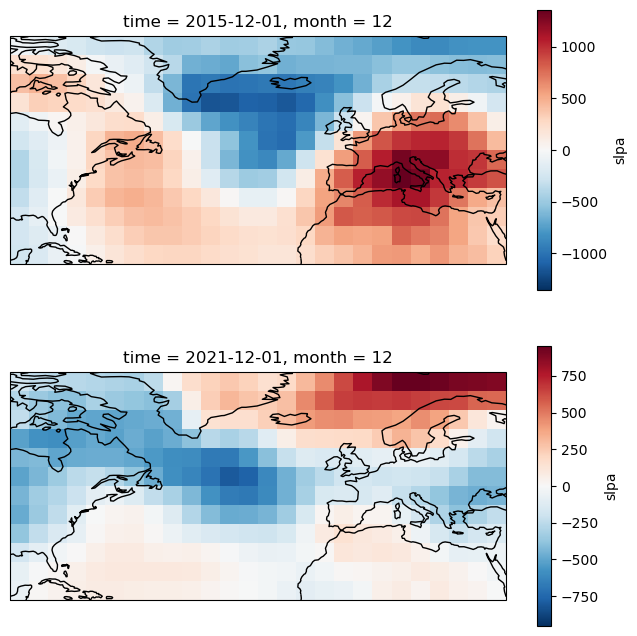

In [2]:
# Read data from file
da = xr.open_dataset("./data/Data/slpa_1950_2021.nc")["slpa"]

# Plot last year december, i.e. '2015-12'
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8), subplot_kw=dict(
    projection= ctp.crs.PlateCarree())
)
da.sel(time='2015-12').plot(ax=ax1, transform=ctp.crs.PlateCarree())
ax1.coastlines()
da.sel(time='2021-12').plot(ax=ax2, transform=ctp.crs.PlateCarree())
ax2.coastlines()

#Problem: have to import 2 file

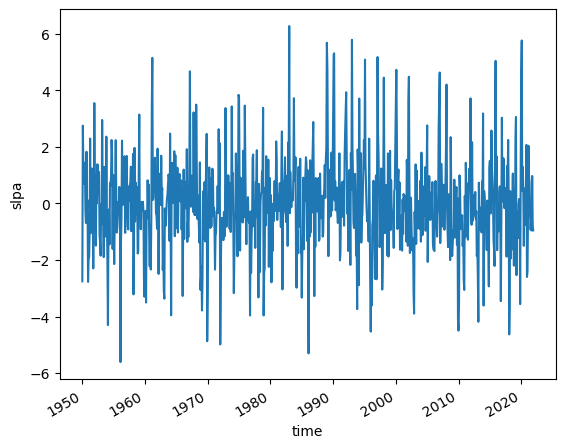

In [3]:
def normalize(da):
    """Normalize data by its standard deviation.

    x_norm = (x - mean_x)/ std_x
    
    Args:
        da (xr.DataArray): Input time-series.

    Returns:
        (xr.DataArray) Normalized time-series.
    """
    flatten = da.stack(temp=da.dims)
    mean = flatten.mean(skipna=True)
    std = flatten.std(skipna=True)
    norm_da = (flatten - mean) / std

    return norm_da.unstack('temp')


# Compute the station-based index and plot the time series
# Your Code here
# ==============
ts_rey = da.sel(lat=64, lon=21, method='nearest')
ts_lis = da.sel(lat=38, lon=9, method='nearest')

#normalizations
ts_rey_normed  = normalize(ts_rey)
ts_lis_normed = normalize(ts_lis)

#nao = lis(normalized) - ry(normalized)
nao= ts_lis_normed - ts_rey_normed

#plot the estimated North Atlantic Oscillation (NAO) index
nao.plot()

# ==============

In [4]:
class SLPA(Dataset):
    """Dataset of SSTA used for pytorch.

    Args:
        dataarray (xr.DataArray): Dataarray containing SSTA. 
    """
    def __init__(self, dataarray):
        self.time = dataarray['time'].data
        self.lat = dataarray['lat'].data
        self.lon = dataarray['lon'].data
        
        # Normalize dataarray by standard deviation
        # Overwrite 
        self.dataarray = None
        # Your Code here
        # ===================================
        self.dataarray = normalize(dataarray)

        # ====================================
        
        # Flatten map to vector
        X = self.dataarray.data.reshape(self.dataarray.shape[0], -1)
        # Remove Nans in vector
        self.idx_nan = np.isnan(X[0,:])
        self.X = X[:, ~self.idx_nan]
        

    def __len__(self):
        """Returns the number of datapoints."""
        return len(self.dataarray)
    

    def __getitem__(self, idx):
        """Required function to get items of dataset.

        Args:
            idx (int): Index to get datapoint.
        Returns:
            x (torch.Tensor): Datapoint of dimension (channel, lat, lon)
            l (dict): Label of datapoint. In this case just the index.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        x = torch.from_numpy(self.X[idx]).float()
        label = {'idx': idx}

        return x, label
    
    def get_map(self, x, name=None):
        """Reshape flattened vector with removed NaNs to xarray map.

        Args:
            data (torch.tensor): (x_dim) Flatten datapoint with NaNs removed

        Return:
            map (np.ndarray): 2d-map
        """
        if torch.is_tensor(x):
            x = x.to('cpu').detach().numpy()

        # Create array with NaNs
        x_map = np.ones((len(self.lat) * len(self.lon))) * np.NaN
        # fill array with sample
        x_map[~self.idx_nan] = x

        da_map = xr.DataArray(
            data=np.reshape(x_map, (len(self.lat), len(self.lon))),
            dims=['lat', 'lon'],
            coords=dict(lat=self.lat, lon=self.lon)
        )
        return da_map 

In [5]:
dataset = SLPA(da)
# Sample datapoint
x, l = dataset[0]
x_dim = x.shape[0]
print(f"Shape of datapoint: {x_dim}")

Shape of datapoint: 312


In [6]:
n_training = int(len(dataset) * 0.8)
(train_data, val_data) = torch.utils.data.random_split(dataset, [n_training, len(dataset) - n_training])

# Define data loader
batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
print(train_loader)

In [ ]:
code until here:excercise_ae_slp
follow code: Übung1_1

In [7]:
# Layer details for the neural network
input_size = 784                      #size?
hidden_sizes = [128, 64]              #size?
output_size = 10                      #size?

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

In [22]:
# Download and load the training data
trainset = da
valset = da
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)


In [23]:
dataiter = iter(trainloader)

In [24]:
from torch import nn

# Layer details for the neural network
input_size = 784               #size?
hidden_sizes = [128, 64]       #size?
output_size = 10               #size?

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

In [ ]:
# loss 
'''criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)
'''

In [25]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None


NameError: name 'loss' is not defined

In [26]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [27]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))                       # wrong
images.resize_(64, 784)                                        # wrong

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)                                          # wrong
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[-0.0019,  0.0139, -0.0268,  ..., -0.0217,  0.0018,  0.0075],
        [ 0.0272,  0.0027,  0.0255,  ...,  0.0115,  0.0221,  0.0128],
        [ 0.0237,  0.0188,  0.0005,  ..., -0.0214, -0.0047,  0.0123],
        ...,
        [ 0.0071,  0.0065, -0.0086,  ..., -0.0333, -0.0223,  0.0043],
        [ 0.0170,  0.0099, -0.0186,  ...,  0.0297, -0.0220, -0.0136],
        [-0.0213,  0.0056,  0.0043,  ...,  0.0057, -0.0105,  0.0240]],
       requires_grad=True)


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'xarray.core.dataarray.DataArray'>

In [28]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[-0.0019,  0.0139, -0.0268,  ..., -0.0217,  0.0018,  0.0075],
        [ 0.0272,  0.0027,  0.0255,  ...,  0.0115,  0.0221,  0.0128],
        [ 0.0237,  0.0188,  0.0005,  ..., -0.0214, -0.0047,  0.0123],
        ...,
        [ 0.0071,  0.0065, -0.0086,  ..., -0.0333, -0.0223,  0.0043],
        [ 0.0170,  0.0099, -0.0186,  ...,  0.0297, -0.0220, -0.0136],
        [-0.0213,  0.0056,  0.0043,  ...,  0.0057, -0.0105,  0.0240]],
       requires_grad=True)


In [30]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
# time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'xarray.core.dataarray.DataArray'>

In [31]:
correct_count, all_count = 0, 0
for images,labels in valloader:                                             # wrong
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'xarray.core.dataarray.DataArray'>